# Verificarlo Tutorial

**Authors:** pablo.oliveira@uvsq.fr; eric.petit@intel.com; yohan.chatelain@uvsq.fr; francois.fevotte@edf.fr; bruno.lathuiliere@edf.fr; david.defour@univ-perp.fr

**Affiliations:** Université de Versailles - Intel - EDF - Université de Perpignan

https://github.com/verificarlo/verificarlo

---

## 0. Setup: Install Verificarlo

This cell installs Verificarlo from source on Google Colab. It installs LLVM, builds Verificarlo, and adds it to the PATH.

**Note:** This installation step only needs to run once per Colab session.

In [57]:
%%bash
set -e

# Skip if already installed
if command -v verificarlo-c &> /dev/null; then
    echo "Verificarlo is already installed."
    verificarlo-c --version
    exit 0
fi

echo "=== Installing Verificarlo dependencies ==="
apt-get update -qq
apt-get install -y -qq autoconf automake libtool build-essential \
    libmpfr-dev python3-dev python3-pip git \
    llvm-14-dev clang-14 2>&1 | tail -1

pip install -q numpy scipy pandas significantdigits

echo "=== Cloning Verificarlo ==="
git clone --depth 1 https://github.com/verificarlo/verificarlo.git /tmp/verificarlo 2>&1 | tail -1

echo "=== Building Verificarlo ==="
cd /tmp/verificarlo
./autogen.sh 2>&1 | tail -1
./configure --with-llvm=$(llvm-config-14 --prefix) --without-flang --without-prism 2>&1 | tail -1
make install-interflop-stdlib 2>&1 | tail -1
make -j$(nproc) 2>&1 | tail -1
make install 2>&1 | tail -1

echo "=== Verificarlo installed successfully ==="
verificarlo-c --version

Verificarlo is already installed.
verificarlo 2.3.1


In [58]:
import subprocess
import os
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12

# Working directory for compiled programs
WORKDIR = '/tmp/vfc_tutorial'
os.makedirs(WORKDIR, exist_ok=True)

# Set up library path
os.environ['LD_LIBRARY_PATH'] = '/usr/local/lib' + ':' + os.environ.get('LD_LIBRARY_PATH', '')

---

## 1. Verificarlo Basics

To debug or optimize floating-point computation with Verificarlo, the first step is to compile your program with it. Verificarlo is built as a set of LLVM plugins; to compile a program with `verificarlo-c` you should use it instead of the usual `clang`, `icc` or `gcc`.

Once a program is compiled with Verificarlo, you can load various backends to simulate round-off noise or the effect of lower floating-point precisions. Backends are selected and configured by defining the `VFC_BACKENDS` environment variable.

---

## 2. Monte Carlo Arithmetic: Polynomial Evaluation

Polynomial evaluation is a common source of computational error. Polynomials are frequently used for function interpolation in libraries or user codes. Different evaluations of the same polynomial do not have the same behavior in terms of performance or numerical accuracy.

This tutorial uses the Tchebychev polynomial from Parker (1997), *Monte Carlo Arithmetic*, section 8.1.2 pp.52-54:

$$T(x) = \sum_{i=0}^{10} a_i \times x^{2i}$$

With coefficients:
$a_i \in [1,\; -200,\; 6600,\; -84480,\; 549120,\; -2050048,\; 4659200,\; -6553600,\; 5570560,\; -2621440,\; 524288]$

Due to catastrophic cancellations, the polynomial is difficult to evaluate near $x = 1$.

### 2.1 Writing the C Source Files

We write the Tchebychev polynomial evaluation program and the Error-Free Transformation (EFT) library directly from the notebook.

In [59]:
%%writefile /tmp/vfc_tutorial/eft.h
/* Simple implementation of Error Free Transformations
 * TWOPROD(REAL a, REAL b, REAL *x, REAL *e);
 * TWOSUM(REAL a, REAL b, REAL *x, REAL *e);
 */

#ifndef __EFT_H__
#define __EFT_H__

#ifdef DOUBLE
#define TWOPROD twoprod_d
#define TWOSUM twosum_d
#else
#define TWOPROD twoprod_s
#define TWOSUM twosum_s
#endif

void twosum_s(float a, float b, float *x, float *e);
void twoprod_s(float a, float b, float *x, float *e);

void twosum_d(double a, double b, double *x, double *e);
void twoprod_d(double a, double b, double *x, double *e);

#endif

Overwriting /tmp/vfc_tutorial/eft.h


In [60]:
%%writefile /tmp/vfc_tutorial/eft.c
#include "eft.h"

void split_s(float a, float *x, float *y){
  const float c = 4097 * a;
  (*x) = c - (c-a);
  (*y) = a - (*x);
}

void twosum_s(float a, float b, float *x, float *e) {
  (*x) = a + b;
  const float z = (*x) - a;
  (*e) = (a - ((*x)-z)) + (b-z);
}

void twoprod_s(float a, float b, float *x, float *e) {
  (*x) = a * b;
  float a1, a2, b1, b2;
  split_s(a, &a1, &a2);
  split_s(b, &b1, &b2);
  const float tmp = (a1*b1-(*x)) + a1*b2 + a2*b1;
  (*e) = tmp + a2*b2;
}

void split_d(double a, double *x, double *y){
  const double c = 134217729 * a;
  (*x) = c - (c-a);
  (*y) = a - (*x);
}

void twosum_d(double a, double b, double *x, double *e) {
  (*x) = a + b;
  const double z = (*x) - a;
  (*e) = (a - ((*x)-z)) + (b-z);
}

void twoprod_d(double a, double b, double *x, double *e) {
  (*x) = a * b;
  double a1, a2, b1, b2;
  split_d(a, &a1, &a2);
  split_d(b, &b1, &b2);
  const double tmp = (a1*b1-(*x)) + a1*b2 + a2*b1;
  (*e) = tmp + a2*b2;
}

Overwriting /tmp/vfc_tutorial/eft.c


In [61]:
%%writefile /tmp/vfc_tutorial/tchebychev.c
/* Verificarlo Tutorial: Tchebychev Polynomial Evaluation */

#include <assert.h>
#include <float.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include "eft.h"

/* Define real type and format string */
#ifdef DOUBLE
#define REAL double
#define FMT "%.16e %.16e"
#else
#define REAL float
#define FMT "%.7e %.7e"
#endif

/* Coefficients of the Tchebychev polynomial */
REAL a[] = {1.,       -200.,     6600.,    -84480.,   549120., -2050048.,
            4659200., -6553600., 5570560., -2621440., 524288.};

/* Expanded naive implementation of the polynomial evaluation */
REAL expanded(REAL x) {
  REAL r = a[0];
  REAL x2 = x * x;
  REAL p = x2;
  for (int i = 1; i <= 10; i++) {
    r += a[i] * p;
    p *= x2;
  }
  return r;
}

/* Factored polynomial evaluation */
REAL factored(REAL x) {
  REAL r = 0.0;
  REAL x2 = x * x;
  r = 8.0 * x2;
  r *= (x - 1.0);
  r *= (x + 1.0);
  r *= (4.0 * x2 + 2.0 * x - 1.0) * (4.0 * x2 + 2.0 * x - 1.0);
  r *= (4.0 * x2 - 2.0 * x - 1.0) * (4.0 * x2 - 2.0 * x - 1.0);
  r *= (16.0 * x2 * x2 - 20.0 * x2 + 5.0) * (16.0 * x2 * x2 - 20.0 * x2 + 5.0);
  r += 1.0;
  return r;
}

/* Horner polynomial evaluation */
REAL horner(REAL x) {
  REAL r = a[10];
  REAL x2 = x * x;
  for (int i = 9; i >= 0; i--) {
    r = r * x2 + a[i];
  }
  return r;
}

/* Compensated Horner polynomial evaluation */
REAL compHorner(REAL x) {
  REAL r = a[10];
  REAL x2 = x * x;
  REAL s = 0;
  for (int i = 9; i >= 0; i--) {
    REAL p, pe, se;
    TWOPROD(r, x2, &p, &pe);
    TWOSUM(p, a[i], &r, &se);
    s = s * x2 + (pe + se);
  }
  return r + s;
}

void usage(void) {
  fprintf(stderr, "usage: tchebychev x [EXPANDED | HORNER | FACTORED | COMPHORNER]\n"
                  "       x is a floating point value\n");
  exit(EXIT_FAILURE);
}

int main(int argc, char **argv) {
  if (argc != 3) usage();
  REAL x = atof(argv[1]);
  char *method = argv[2];
  REAL r;

  if (strcmp(method, "EXPANDED") == 0)
    r = expanded(x);
  else if (strcmp(method, "HORNER") == 0)
    r = horner(x);
  else if (strcmp(method, "FACTORED") == 0)
    r = factored(x);
  else if (strcmp(method, "COMPHORNER") == 0)
    r = compHorner(x);
  else
    usage();

  printf(FMT "\n", x, r);
  return EXIT_SUCCESS;
}

Overwriting /tmp/vfc_tutorial/tchebychev.c


### 2.2 Compiling with Verificarlo

We compile `tchebychev.c` with `verificarlo-c` for both **single (FLOAT)** and **double (DOUBLE)** precision. We also compile `eft.c` for the compensated Horner method.

In [62]:
%%bash
cd /tmp/vfc_tutorial

# Compile for single precision (FLOAT)
verificarlo-c -D FLOAT tchebychev.c eft.c -o tchebychev_float -lm
echo "Compiled tchebychev_float (single precision)"

# Compile for double precision (DOUBLE)
verificarlo-c -D DOUBLE tchebychev.c eft.c -o tchebychev_double -lm
echo "Compiled tchebychev_double (double precision)"

Compiled tchebychev_float (single precision)
Compiled tchebychev_double (double precision)


### 2.3 First Steps: IEEE and MCA Backends

The simplest backend emulates IEEE-754 arithmetic (`libinterflop_ieee.so`). It has a `--debug` option that traces each instrumented floating-point operation.

The MCA backend (`libinterflop_mca.so`) simulates round-off errors at a chosen virtual precision. Running the same program multiple times gives different results, revealing the numerical instability.

In [63]:
%%bash
cd /tmp/vfc_tutorial

echo "=== IEEE backend (deterministic) ==="
VFC_BACKENDS="libinterflop_ieee.so" ./tchebychev_float 0.99 EXPANDED

echo ""
echo "=== MCA backend, precision=24, 5 runs (stochastic) ==="
for i in $(seq 1 5); do
    VFC_BACKENDS="libinterflop_mca.so --precision-binary32=24" ./tchebychev_float 0.99 EXPANDED
done

echo ""
echo "Notice how MCA produces different results each run near x=1,"
echo "revealing the numerical instability due to catastrophic cancellations."

=== IEEE backend (deterministic) ===
9.9000001e-01 -8.7500000e-01

=== MCA backend, precision=24, 5 runs (stochastic) ===
9.9000001e-01 -1.0000000e+00
9.9000001e-01 -1.1250000e+00
9.9000001e-01 -1.5312500e+00
9.9000001e-01 -5.9375000e-01
9.9000001e-01 -1.0312500e+00

Notice how MCA produces different results each run near x=1,
revealing the numerical instability due to catastrophic cancellations.


Info [verificarlo]: loaded backend libinterflop_ieee.so
Info [interflop-ieee]: load backend with:
Info [interflop-ieee]: debug = false
Info [interflop-ieee]: debug-binary = false
Info [interflop-ieee]: no-backend-name = false
Info [interflop-ieee]: print-new-line = false
Info [interflop-ieee]: print-subnormal-normalized = false
Info [interflop-ieee]: count-op = false
Info [verificarlo]: loaded backend libinterflop_mca.so
Info [interflop-mcaquad]: load backend with:
Info [interflop-mcaquad]: precision-binary32 = 24
Info [interflop-mcaquad]: precision-binary64 = 53
Info [interflop-mcaquad]: mode = mca
Info [interflop-mcaquad]: error-mode = rel
Info [interflop-mcaquad]: max-abs-error-exponent = 112
Info [interflop-mcaquad]: daz = false
Info [interflop-mcaquad]: ftz = false
Info [interflop-mcaquad]: sparsity = 1.000000
Info [interflop-mcaquad]: seed = 0
Info [verificarlo]: loaded backend libinterflop_mca.so
Info [interflop-mcaquad]: load backend with:
Info [interflop-mcaquad]: precision-bi

The Monte Carlo Arithmetic backend supports different modes:
- **`rr` (Random Round):** Adds noise on the result only when the operation is not exactly representable at the chosen precision. Simulates round-off errors.
- **`pb` (Precision Bound):** Adds noise on the operands before performing the operation. Simulates cancellation errors.
- **`mca`:** Default mode that combines `rr` and `pb`.

### 2.4 Numerical Quality Analysis

We now run the polynomial evaluation across the interval $[0, 1]$ with multiple Monte Carlo samples to analyze the numerical quality.

For each value of $x$, we compute:
- The **mean** $\hat{\mu}$ and **standard deviation** $\hat{\sigma}$
- The number $s$ of **significant digits**: $s = -\log_{10}\left|\dfrac{\hat{\sigma}}{\hat{\mu}}\right|$

In [64]:
def run_verificarlo(binary, method, backend_env, x_values, n_samples=20):
    """Run a verificarlo-compiled binary and collect samples.

    Returns a dict mapping x -> list of T(x) samples.
    """
    env = os.environ.copy()
    env['VFC_BACKENDS'] = backend_env
    results = {}

    for x in x_values:
        samples = []
        for _ in range(n_samples):
            proc = subprocess.run(
                [binary, f'{x:.6f}', method],
                capture_output=True, text=True, env=env
            )
            parts = proc.stdout.strip().split()
            if len(parts) == 2:
                samples.append(float(parts[1]))
        results[x] = samples

    return results


def compute_statistics(results, precision_bits):
    """Compute mu, sigma, significant digits from MCA samples."""
    prec_dec = precision_bits * math.log10(2)
    x_vals, mu_vals, sigma_vals, s_vals, all_samples = [], [], [], [], []

    for x in sorted(results.keys()):
        samples = results[x]
        if not samples:
            continue
        mu = np.mean(samples)
        sigma = np.std(samples)

        if sigma == 0:
            s = prec_dec
        elif mu == 0:
            s = 0
        else:
            s = min(-math.log10(sigma / abs(mu)), prec_dec)

        x_vals.append(x)
        mu_vals.append(mu)
        sigma_vals.append(sigma)
        s_vals.append(s)
        all_samples.append(samples)

    return (np.array(x_vals), np.array(mu_vals),
            np.array(sigma_vals), np.array(s_vals), all_samples)


def plot_mca_analysis(x_vals, mu, sigma, s, all_samples, title, prec_bits):
    """Plot MCA analysis: significant digits, standard deviation, and samples."""
    prec_dec = prec_bits * math.log10(2)
    fig, axes = plt.subplots(3, 1, figsize=(10, 8))
    fig.suptitle(title, fontsize=14)

    axes[0].plot(x_vals, s, '.', markersize=3)
    axes[0].set_ylabel('$s$')
    axes[0].set_ylim(bottom=-1)
    axes[0].axhline(y=prec_dec, color='gray', linestyle='--', alpha=0.5)

    axes[1].plot(x_vals, sigma, '.', markersize=3)
    axes[1].set_ylabel(r'$\hat{\sigma}$')

    for i, x in enumerate(x_vals):
        axes[2].plot([x] * len(all_samples[i]), all_samples[i],
                     'k.', alpha=0.3, markersize=1)
    axes[2].plot(x_vals, mu, '--', color='r', linewidth=1)
    axes[2].set_xlabel('$x$')
    axes[2].set_ylabel(r'$T(x)$ and $\hat{\mu}$')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

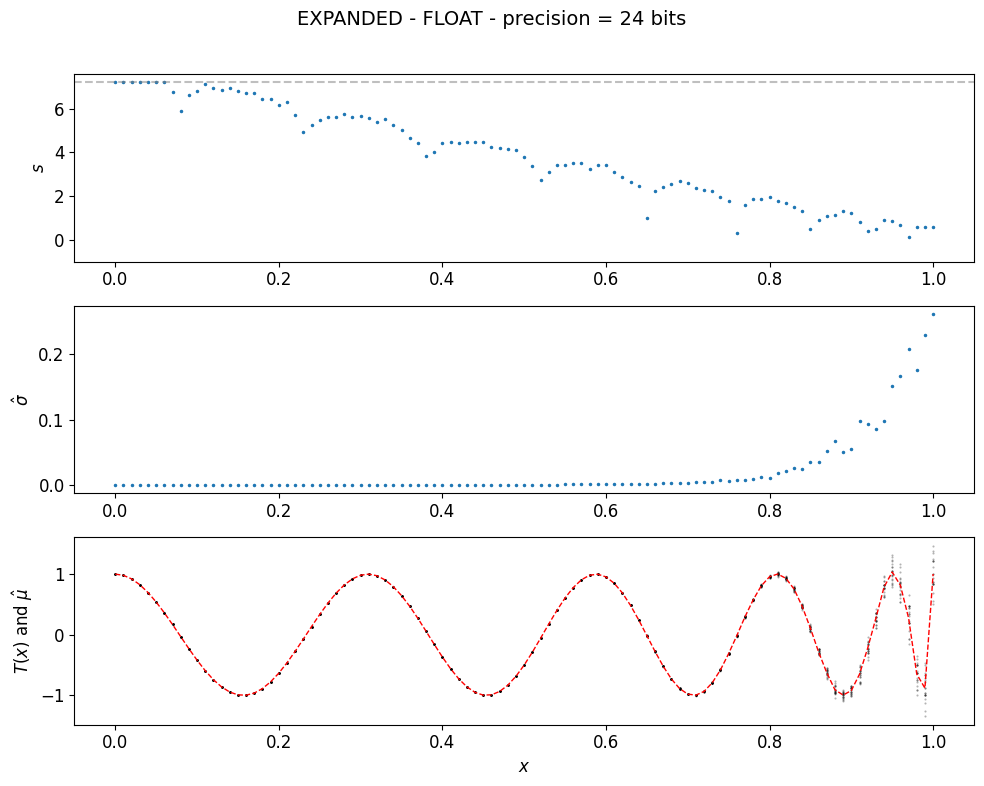

In [65]:
# EXPANDED, single precision (FLOAT), virtual precision = 24 bits
x_range = np.arange(0.0, 1.01, 0.01)

results_exp_24 = run_verificarlo(
    f'{WORKDIR}/tchebychev_float', 'EXPANDED',
    'libinterflop_mca.so --precision-binary32=24 --mode mca',
    x_range, n_samples=20
)

x_v, mu, sigma, s, samples = compute_statistics(results_exp_24, 24)
plot_mca_analysis(x_v, mu, sigma, s, samples,
                  'EXPANDED - FLOAT - precision = 24 bits', 24)

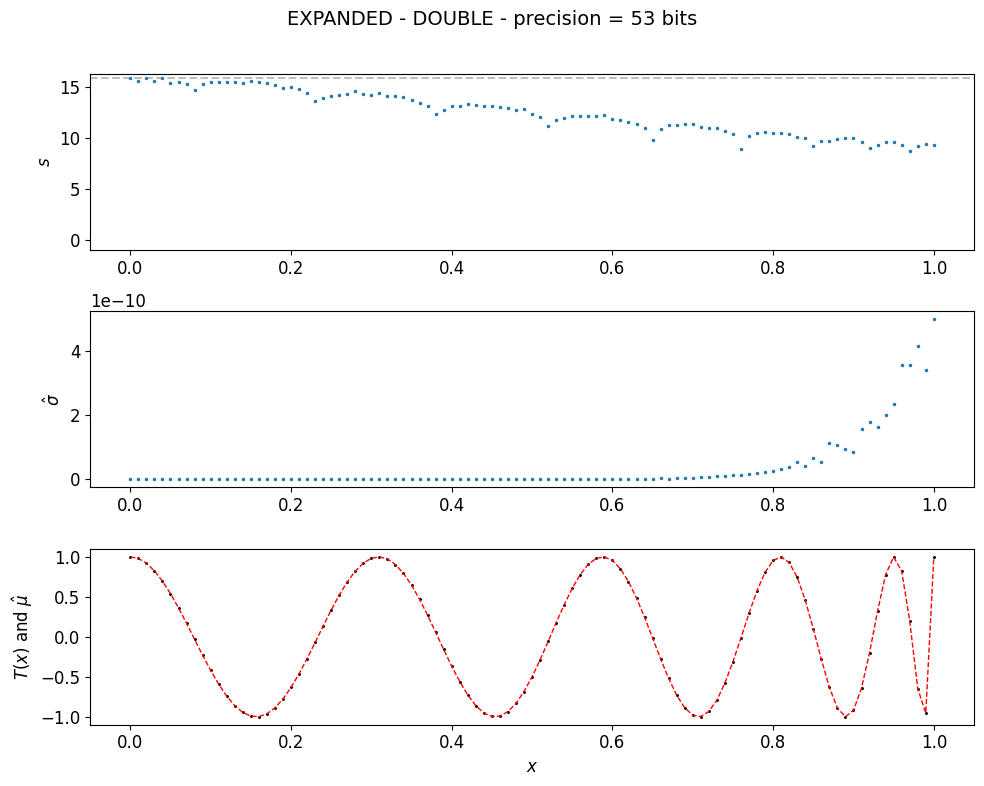

In [66]:
# EXPANDED, double precision (DOUBLE), virtual precision = 53 bits
results_exp_53 = run_verificarlo(
    f'{WORKDIR}/tchebychev_double', 'EXPANDED',
    'libinterflop_mca.so --precision-binary64=53 --mode mca',
    x_range, n_samples=20
)

x_v53, mu53, sigma53, s53, samples53 = compute_statistics(results_exp_53, 53)
plot_mca_analysis(x_v53, mu53, sigma53, s53, samples53,
                  'EXPANDED - DOUBLE - precision = 53 bits', 53)

### Observations

The polynomial evaluation done with 24 bits is subject to severe **catastrophic cancellations** when the input value is close to $1$. This drastically reduces the accuracy of the result.

Using evaluation in double precision (53 bits) seems satisfactory. But this solution forces the developer to use a larger and more expensive data type and **it does not solve the problem -- it only delays it**.

---

## 3. Factored Form

We will now evaluate the precision of the following factored rewriting:

$$T(x) = 1 + 8x^2(x-1)(x+1)(4x^2 + 2x - 1)^2(4x^2 - 2x - 1)^2(16x^4 - 20x^2 + 5)^2$$

**Exercise:**
1. Look at the function `REAL factored(REAL x)` in the C code above.
2. Run FACTORED with single precision and compare to EXPANDED.

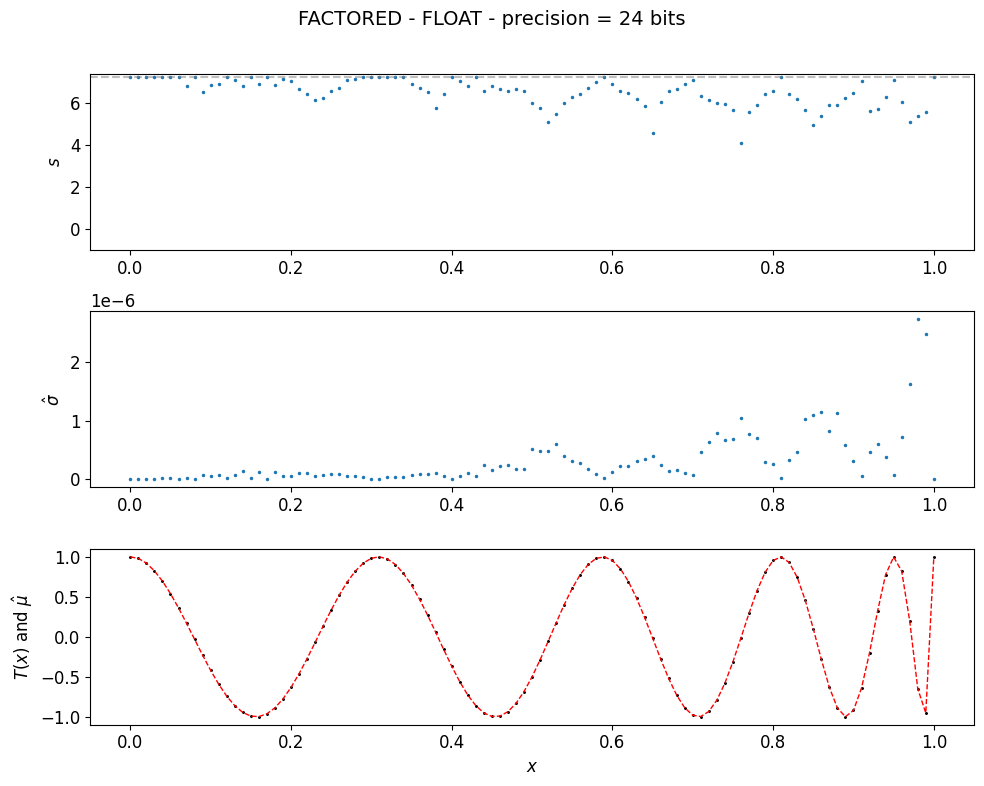

In [67]:
# FACTORED, single precision (FLOAT), virtual precision = 24 bits
results_fac_24 = run_verificarlo(
    f'{WORKDIR}/tchebychev_float', 'FACTORED',
    'libinterflop_mca.so --precision-binary32=24 --mode mca',
    x_range, n_samples=20
)

x_vf, mu_f, sigma_f, s_f, samples_f = compute_statistics(results_fac_24, 24)
plot_mca_analysis(x_vf, mu_f, sigma_f, s_f, samples_f,
                  'FACTORED - FLOAT - precision = 24 bits', 24)

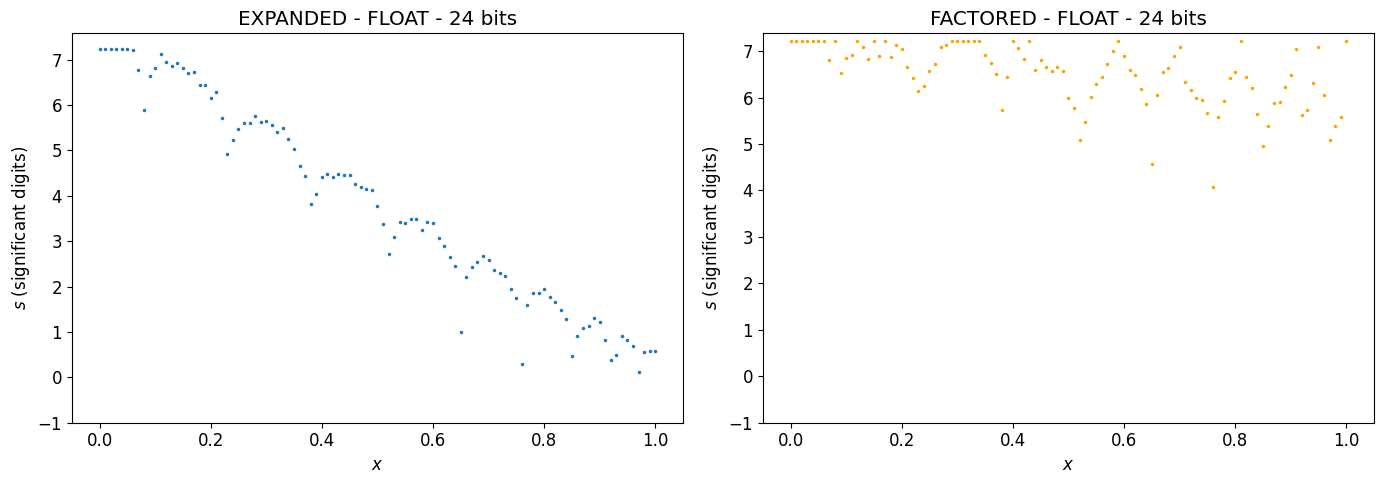

In [68]:
# Side-by-side comparison: EXPANDED vs FACTORED at 24 bits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(x_v, s, '.', markersize=3)
axes[0].set_ylabel('$s$ (significant digits)')
axes[0].set_xlabel('$x$')
axes[0].set_title('EXPANDED - FLOAT - 24 bits')
axes[0].set_ylim(bottom=-1)

axes[1].plot(x_vf, s_f, '.', markersize=3, color='orange')
axes[1].set_ylabel('$s$ (significant digits)')
axes[1].set_xlabel('$x$')
axes[1].set_title('FACTORED - FLOAT - 24 bits')
axes[1].set_ylim(bottom=-1)

plt.tight_layout()
plt.show()

### Observations on the Factored Form

Notice what happens when $T(x) = 1$ for $x \simeq 0.6$, $x \simeq 0.8$ and $x \simeq 0.95$.

We evaluate $T$ on one of the roots of the factored right-hand terms which become zero. It is an example where the error is absorbed and the precision and accuracy of the results are improved.

---

## 4. VPREC: Variable Precision Backend

The VPREC backend emulates reduced floating-point formats without having to change the implementation. It can emulate any format that fits into the original type. Unlike the MCA backend, **VPREC is deterministic**. It mirrors what would happen with the selected reduced type. It correctly handles overflow, underflows, and rounding in the target type.

Options:
- `--precision-binary64` controls the pseudo-mantissa bit length
- `--range-binary64` controls the exponent bit length
- Standard presets: `binary16`, `binary32`, `bfloat16`, `tensorfloat`, `fp24`, `PXR24`

In [69]:
%%bash
cd /tmp/vfc_tutorial

echo "=== VPREC: Emulating binary32 (single precision) using double-precision binary ==="
VFC_BACKENDS="libinterflop_vprec.so --preset=binary32" ./tchebychev_double 0.75 FACTORED

echo ""
echo "=== VPREC: Emulating bfloat16 ==="
VFC_BACKENDS="libinterflop_vprec.so --preset=bfloat16" ./tchebychev_double 0.75 FACTORED

echo ""
echo "=== VPREC: Custom precision = 12 bits ==="
VFC_BACKENDS="libinterflop_vprec.so --precision-binary64=12" ./tchebychev_double 0.75 FACTORED

=== VPREC: Emulating binary32 (single precision) using double-precision binary ===
7.5000000000000000e-01 -3.1220960617065430e-01

=== VPREC: Emulating bfloat16 ===
7.5000000000000000e-01 -3.0468750000000000e-01

=== VPREC: Custom precision = 12 bits ===
7.5000000000000000e-01 -3.1225585937500000e-01


Info [verificarlo]: loaded backend libinterflop_vprec.so
Info [interflop-vprec]: load backend with: 
Info [interflop-vprec]: precision-binary32 = 23
Info [interflop-vprec]: range-binary32 = 8
Info [interflop-vprec]: precision-binary64 = 23
Info [interflop-vprec]: range-binary64 = 8
Info [interflop-vprec]: mode = ob
Info [interflop-vprec]: error-mode = rel
Info [interflop-vprec]: max-abs-error-exponent = -1022
Info [interflop-vprec]: daz = false
Info [interflop-vprec]: ftz = false
Info [interflop-vprec]: 	instrument = none
Info [interflop-vprec]: 	prec-input-file = (null)
Info [interflop-vprec]: 	prec-output-file = (null)
Info [interflop-vprec]: 	prec-log-file = (null)
Info [verificarlo]: loaded backend libinterflop_vprec.so
Info [interflop-vprec]: load backend with: 
Info [interflop-vprec]: precision-binary32 = 7
Info [interflop-vprec]: range-binary32 = 8
Info [interflop-vprec]: precision-binary64 = 7
Info [interflop-vprec]: range-binary64 = 8
Info [interflop-vprec]: mode = ob
Info [in

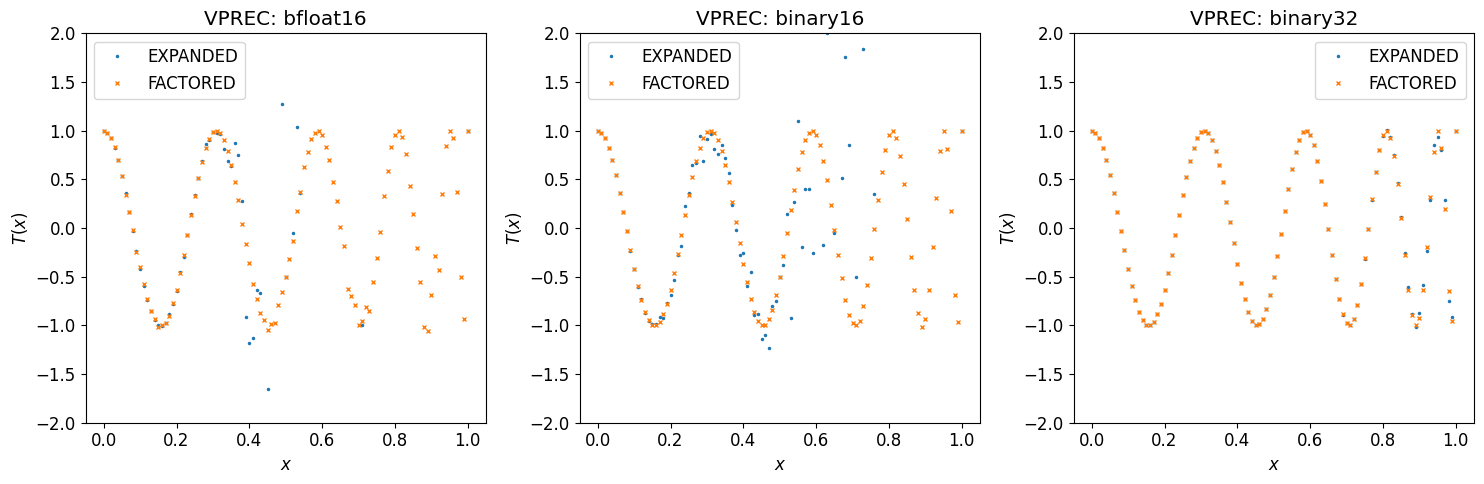

In [70]:
# VPREC sweep: FACTORED and EXPANDED with bfloat16
# Since VPREC is deterministic, only 1 sample per x is needed.

presets = ['--preset=bfloat16', '--preset=binary16', '--preset=binary32']
preset_labels = ['bfloat16', 'binary16', 'binary32']

fig, axes = plt.subplots(1, len(presets), figsize=(5 * len(presets), 5))

for idx, (preset, label) in enumerate(zip(presets, preset_labels)):
    for method, marker in [('EXPANDED', '.'), ('FACTORED', 'x')]:
        results = run_verificarlo(
            f'{WORKDIR}/tchebychev_double', method,
            f'libinterflop_vprec.so {preset}',
            x_range, n_samples=1
        )
        x_vals = sorted(results.keys())
        t_vals = [results[x][0] if results[x] else float('nan') for x in x_vals]
        axes[idx].plot(x_vals, t_vals, marker, markersize=3, label=method)

    axes[idx].set_title(f'VPREC: {label}')
    axes[idx].set_ylabel('$T(x)$')
    axes[idx].set_xlabel('$x$')
    axes[idx].set_ylim(-2, 2)
    axes[idx].legend()

plt.tight_layout()
plt.show()

**Exercise:** Try different precisions with `--precision-binary64=N`. At which threshold does the computation lose all significance?

---

## 5. Pinpointing Bugs with Delta-Debug: Archimedes' Method

In this section we demonstrate how Verificarlo can precisely localize a numerical bug in a program. The localization method is based on Zeller's Delta-Debug reduction method.

### Archimedes' Algorithm

In 200 BC, Archimedes proposed the first numerical method for computing $\pi$. The half-perimeter of circumscribed polygons converges to $\pi$ via the recursive sequence:

$$T_1 = \frac{1}{\sqrt{3}}, \quad T_{i+1} = \frac{\sqrt{T_i^2 + 1} - 1}{T_i}, \quad \frac{P_i}{2} = 6 \times 2^{i-1} \times T_i \xrightarrow[i \to \infty]{} \pi$$

In [71]:
%%writefile /tmp/vfc_tutorial/archimedes.c
#include <math.h>
#include <stdio.h>
#include <time.h>

/* Archimedes method for computing PI using circumscribed polygons */
double archimedes(int N) {
  double ti, tii, fact, res;
  int i;

  /* Print header */
  fprintf(stderr, " i Ai+1                  Ti+1\n");

  ti = 1. / sqrt(3.);
  fact = 1;
  for (i = 1; i <= N; i++) {
    double s = sqrt(ti * ti + 1);
    tii = (s - 1) / ti;
    ti = tii;
    fact *= 2;
    res = 6 * fact * tii;
    fprintf(stderr, "%2d %.15e %.15e\n", i, res, tii);
  }
  return res;
}

int main(void) {
  /* Approximate pi with 25 iterations of the Archimedes method */
  const int N = 25;
  double pi = archimedes(N);
  printf("%.15e\n", pi);
  return 0;
}


Overwriting /tmp/vfc_tutorial/archimedes.c


In [72]:
%%bash
cd /tmp/vfc_tutorial

# Compile Archimedes with verificarlo
verificarlo-c --ddebug -O0 -g archimedes.c -o archimedes -lm --inst-fma
echo "Compiled archimedes"

echo ""
echo "=== IEEE backend (deterministic) ==="
VFC_BACKENDS="libinterflop_ieee.so" ./archimedes

Compiled archimedes

=== IEEE backend (deterministic) ===
2.791117213058638e+00


Info [verificarlo]: loaded backend libinterflop_ieee.so
Info [interflop-ieee]: load backend with:
Info [interflop-ieee]: debug = false
Info [interflop-ieee]: debug-binary = false
Info [interflop-ieee]: no-backend-name = false
Info [interflop-ieee]: print-new-line = false
Info [interflop-ieee]: print-subnormal-normalized = false
Info [interflop-ieee]: count-op = false
 i Ai+1                  Ti+1
 1 3.215390309173475e+00 2.679491924311229e-01
 2 3.159659942097510e+00 1.316524975873962e-01
 3 3.146086215131467e+00 6.554346281523889e-02
 4 3.142714599645573e+00 3.273661041297472e-02
 5 3.141873049979866e+00 1.636392213531180e-02
 6 3.141662747055068e+00 8.181413403789240e-03
 7 3.141610176599522e+00 4.090638250780627e-03
 8 3.141597034323337e+00 2.045310569220922e-03
 9 3.141593748816856e+00 1.022654215109654e-03
10 3.141592927873633e+00 5.113269739377658e-04
11 3.141592725622592e+00 2.556634705096510e-04
12 3.141592671741545e+00 1.278317330624001e-04
13 3.141592618900886e+00 6.391586545

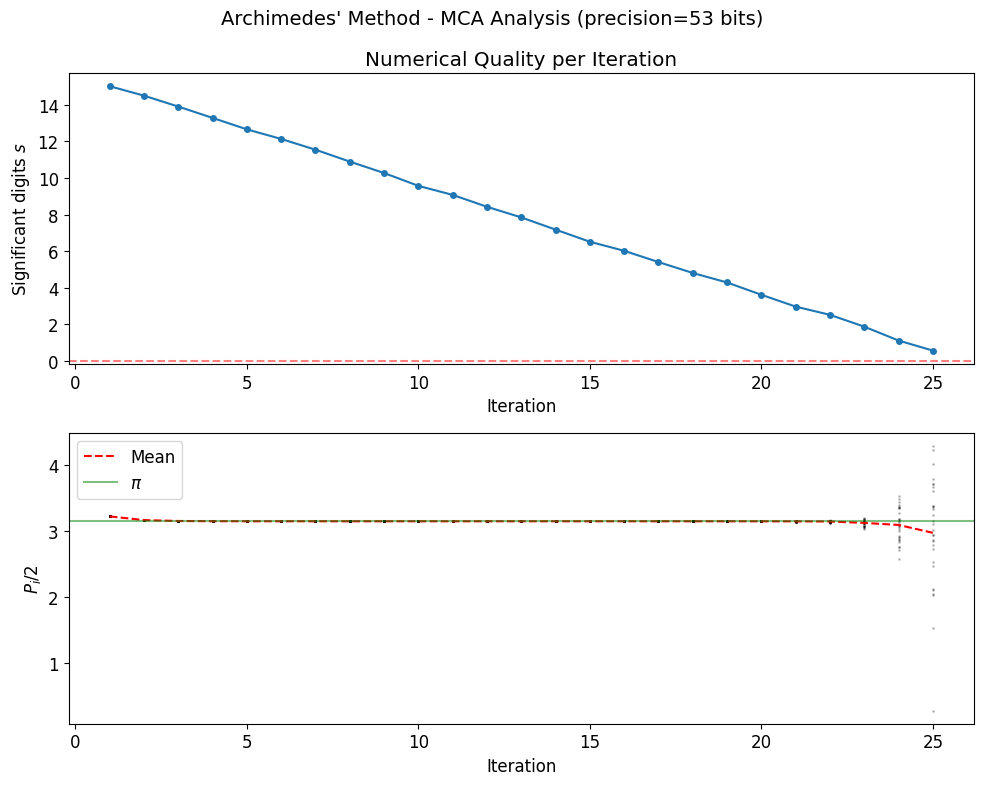

In [73]:
# Run Archimedes with MCA to visualize the instability
env = os.environ.copy()
env['VFC_BACKENDS'] = 'libinterflop_mca.so --precision-binary64=53 --mode mca'
# Disable verificarlo logger
env['VFC_BACKENDS_LOGGER'] = 'False'

n_samples = 30
all_results = []

for _ in range(n_samples):
    proc = subprocess.run(
        [f'{WORKDIR}/archimedes'],
        capture_output=True, text=True, env=env
    )
    # Parse stderr for per-iteration values
    lines = proc.stderr.strip().split('\n')[1:]  # skip header
    run_data = []
    for line in lines:
        parts = line.split()
        if len(parts) >= 2:
            run_data.append(float(parts[1]))  # Ai+1 (approximation to pi)
    all_results.append(run_data)

all_results = np.array(all_results)
N = all_results.shape[1]
iterations = np.arange(1, N + 1)
mu_arch = np.mean(all_results, axis=0)
sigma_arch = np.std(all_results, axis=0)

s_arch = []
for i in range(N):
    if sigma_arch[i] == 0:
        s_arch.append(16)
    elif mu_arch[i] == 0:
        s_arch.append(0)
    else:
        s_arch.append(min(-math.log10(sigma_arch[i] / abs(mu_arch[i])), 16))

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle("Archimedes' Method - MCA Analysis (precision=53 bits)", fontsize=14)

axes[0].plot(iterations, s_arch, 'o-', markersize=4)
axes[0].set_ylabel('Significant digits $s$')
axes[0].set_xlabel('Iteration')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0].set_title('Numerical Quality per Iteration')

for sample in all_results:
    axes[1].plot(iterations, sample, 'k.', alpha=0.2, markersize=2)
axes[1].plot(iterations, mu_arch, 'r--', linewidth=1.5, label='Mean')
axes[1].axhline(y=math.pi, color='g', linestyle='-', alpha=0.5, label='$\\pi$')
axes[1].set_ylabel('$P_i / 2$')
axes[1].set_xlabel('Iteration')
axes[1].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Understanding the Bug with Delta-Debug

Delta-Debug (DD) is a general bug reduction method that efficiently finds a minimal set of conditions that trigger a bug. DD tests instruction subsets and their complements to find smaller failing sets step by step.

| Step | Instructions with MCA noise | Numerically Stable |
|:----:|:---------------------------:|:------------------:|
|  1   | 1 2 3 4 . . . .             | stable             |
|  2   | . . . . 5 6 7 8             | unstable           |
|  3   | . . . . 5 6 . .             | stable             |
|  4   | . . . . . . 7 8             | unstable           |
|  5   | . . . . . . 7 .             | unstable           |
| Result (ddmin) | . . . . . . 7 .    |                    |

In [74]:
%%writefile /tmp/vfc_tutorial/ddRun
#!/bin/bash
OUTDIR=$1
/tmp/vfc_tutorial/archimedes >${OUTDIR}/res.dat

Overwriting /tmp/vfc_tutorial/ddRun


In [75]:
%%writefile /tmp/vfc_tutorial/ddCmp
#!/usr/bin/env python3
from fractions import Fraction
import math
import sys

MAX_DEVIATION=1e-6
REFDIR=sys.argv[1]
CURDIR=sys.argv[2]

def read_output(DIR):
    with open("{}/res.dat".format(DIR)) as f:
        return Fraction(f.read())

# Read reference and current outputs
ref = read_output(REFDIR)
cur = read_output(CURDIR)

# Compute the deviation
mean = abs(float((ref + cur)/2))
std = math.sqrt(float((ref - mean)**2 + (ref - cur)**2))
deviation = std/mean # dev = sigma / | mu |

# Write log to CURDIR/res.stat
with open("{}/res.stat".format(CURDIR), 'w') as f:
    f.write("reference = {} current = {} deviation = {}\n".format(
        ref, cur, deviation))

# Fail if the deviation is higher than 1e-6
sys.exit(0 if deviation < MAX_DEVIATION else 1)

Overwriting /tmp/vfc_tutorial/ddCmp


In [76]:
%%bash
chmod +x /tmp/vfc_tutorial/ddRun /tmp/vfc_tutorial/ddCmp

cd /tmp/vfc_tutorial

rm -rf dd.line/

echo "=== Running Delta-Debug ==="
VFC_BACKENDS="libinterflop_mca.so --precision-binary64=53 -m mca" \
    vfc_ddebug ddRun ddCmp 2>&1 | tail -20

echo ""
echo "=== Delta-Debug Results ==="
echo "--- ddmin0 ---"
cat dd.line/ddmin0/dd.line.include 2>/dev/null || echo "(not found)"
echo "--- ddmin1 ---"
cat dd.line/ddmin1/dd.line.include 2>/dev/null || echo "(not found)"
echo "--- rddmin-cmp (union of culprit instructions) ---"
cat dd.line/rddmin-cmp/dd.line.exclude 2>/dev/null || echo "(not found)"

=== Running Delta-Debug ===
/tmp/vfc_tutorial/dd.line/5eeb6158511549e50e78ea89faf97098 --( run )-> FAIL(0)
/tmp/vfc_tutorial/dd.line/605dd8df319c8ed40ee3fe0bd7650ea6 --( run )-> FAIL(0)
/tmp/vfc_tutorial/dd.line/ac3e7abf6c00df96fbda92ffb559c7ce --( run )-> FAIL(0)
ddmin1 (0x402408: archimedes at archimedes.c:16):
/tmp/vfc_tutorial/dd.line/ac3e7abf6c00df96fbda92ffb559c7ce --(cache) -> FAIL
/tmp/vfc_tutorial/dd.line/ea5c3accdb9490290afbf7c2ea629775 --( run )-> PASS(+3->3)
/tmp/vfc_tutorial/dd.line/c0a9c99ca77850c05175cbd58f76e45f --( run )-> PASS(+3->3)
/tmp/vfc_tutorial/dd.line/dc92bf80a02c805fe06b7da6fa3000a8 --( run )-> PASS(+5->5)
Dichotomy split done
Dichotomy split analyze done
/tmp/vfc_tutorial/dd.line/dc92bf80a02c805fe06b7da6fa3000a8 --(cache)-> PASS(5)
rddmin-cmp (0x402466: archimedes at archimedes.c:20
0x40244f: archimedes at archimedes.c:19
0x4023cc: archimedes at archimedes.c:13
0x40242e: archimedes at archimedes.c:17
0x402470: archimedes at archimedes.c:20):
/tmp/vfc_tutoria

Delta-Debug finds that instructions at lines 16 and 17 of `archimedes.c` are responsible:

```c
double s = sqrt(ti * ti + 1);    // Line 16: round-off error (ti << 1)
tii = (s - 1) / ti;              // Line 17: catastrophic cancellation
```

- **Line 16:** The operation $T_i^2 + 1$ is inexact due to a round-off error ($T_i \ll 1$)
- **Line 17:** The subtraction $s - 1$ triggers a catastrophic cancellation that amplifies the error

### Confirming with different backends

- With **RR 53**: only line 16 is flagged (RR does not perturb cancellations which are exact operations)
- With **cancellation backend**: only line 17 is flagged
- This confirms: round-off error at line 16 + cancellation at line 17

### Fixing the Bug: Expression Rewriting

To fix the cancellation, we multiply by the conjugate:

$$T_{i+1} = \frac{\sqrt{T_i^2+1} - 1}{T_i} \times \frac{\sqrt{T_i^2+1} + 1}{\sqrt{T_i^2+1} + 1} = \frac{T_i}{\sqrt{T_i^2+1} + 1}$$

The new formula eliminates the subtraction that triggered the cancellation.

In [77]:
%%writefile /tmp/vfc_tutorial/archimedes_fixed.c
#include <math.h>
#include <stdio.h>

/* Archimedes method FIXED: no catastrophic cancellation */
double archimedes(int N) {
  double ti, tii, fact, res;
  int i;

  fprintf(stderr, " i Ai+1                  Ti+1\n");

  ti = 1. / sqrt(3.);
  fact = 1;
  for (i = 1; i <= N; i++) {
    double s = sqrt(ti * ti + 1);
    tii = ti / (s + 1);             /* FIXED: no cancellation */
    ti = tii;
    fact *= 2;
    res = 6 * fact * tii;
    fprintf(stderr, "%2d %.15e %.15e\n", i, res, tii);
  }
  return res;
}

int main(void) {
  const int N = 25;
  double pi = archimedes(N);
  printf("%.15e\n", pi);
  return 0;
}

Overwriting /tmp/vfc_tutorial/archimedes_fixed.c


In [78]:
%%bash
cd /tmp/vfc_tutorial

verificarlo-c -g archimedes_fixed.c -o archimedes_fixed -lm --inst-fma
echo "Compiled archimedes_fixed"

echo ""
echo "=== Original (IEEE) ==="
VFC_BACKENDS="libinterflop_ieee.so" ./archimedes 2>/dev/null

echo ""
echo "=== Fixed (IEEE) ==="
VFC_BACKENDS="libinterflop_ieee.so" ./archimedes_fixed 2>/dev/null

echo ""
echo "Reference: pi = 3.141592653589793e+00"

Compiled archimedes_fixed

=== Original (IEEE) ===
2.791117213058638e+00

=== Fixed (IEEE) ===
3.141592653589797e+00

Reference: pi = 3.141592653589793e+00


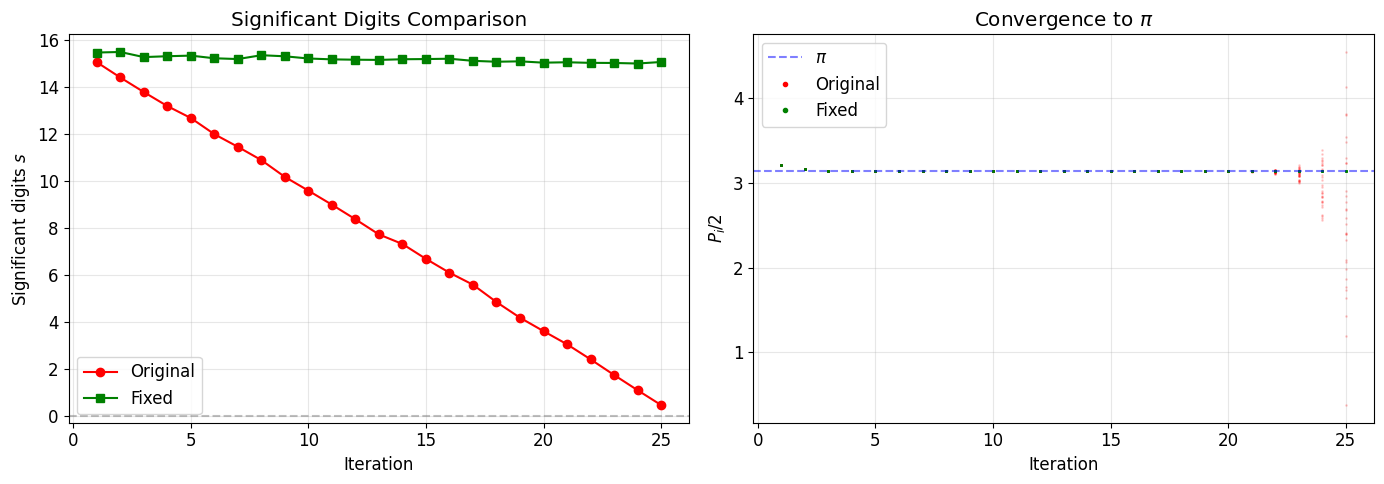

In [79]:
# Compare original vs fixed with MCA
env = os.environ.copy()
env['VFC_BACKENDS'] = 'libinterflop_mca.so --precision-binary64=53 --mode mca'
env['VFC_BACKENDS_LOGGER'] = 'False'

def run_archimedes_mca(binary, env, n_samples=30):
    all_results = []
    for _ in range(n_samples):
        proc = subprocess.run([binary], capture_output=True, text=True, env=env)
        lines = proc.stderr.strip().split('\n')[1:]
        run_data = []
        for line in lines:
            parts = line.split()
            if len(parts) >= 2:
                run_data.append(float(parts[1]))
        all_results.append(run_data)
    return np.array(all_results)

results_orig = run_archimedes_mca(f'{WORKDIR}/archimedes', env)
results_fixed = run_archimedes_mca(f'{WORKDIR}/archimedes_fixed', env)

def compute_sigdigits(results):
    N = results.shape[1]
    mu = np.mean(results, axis=0)
    sigma = np.std(results, axis=0)
    s = []
    for i in range(N):
        if sigma[i] == 0:
            s.append(16)
        elif mu[i] == 0:
            s.append(0)
        else:
            s.append(min(-math.log10(sigma[i] / abs(mu[i])), 16))
    return s

iterations = np.arange(1, results_orig.shape[1] + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(iterations, compute_sigdigits(results_orig), 'o-', color='red', label='Original')
axes[0].plot(iterations, compute_sigdigits(results_fixed), 's-', color='green', label='Fixed')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Significant digits $s$')
axes[0].set_title('Significant Digits Comparison')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for sample in results_orig:
    axes[1].plot(iterations, sample, 'r.', alpha=0.15, markersize=2)
for sample in results_fixed:
    axes[1].plot(iterations, sample, 'g.', alpha=0.15, markersize=2)
axes[1].axhline(y=math.pi, color='blue', linestyle='--', alpha=0.5, label='$\\pi$')
axes[1].plot([], [], 'r.', label='Original')  # legend entries
axes[1].plot([], [], 'g.', label='Fixed')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('$P_i / 2$')
axes[1].set_title('Convergence to $\\pi$')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 6. Bonus Exercises

### 6.1 Polynomial Evaluation using Horner's Method

Horner's method for the considered polynomial:

$$T(x) = (\dots((a_n \times x^2 + a_{n-1}) \times x^2 + a_{n-2})\dots) \times x^2 + a_0$$

The improvement brought by the Horner scheme is not significant ($\simeq$ 1 additional significant bit). However, it minimizes the number of operations and allows use of FMA (Fused Multiply Add).

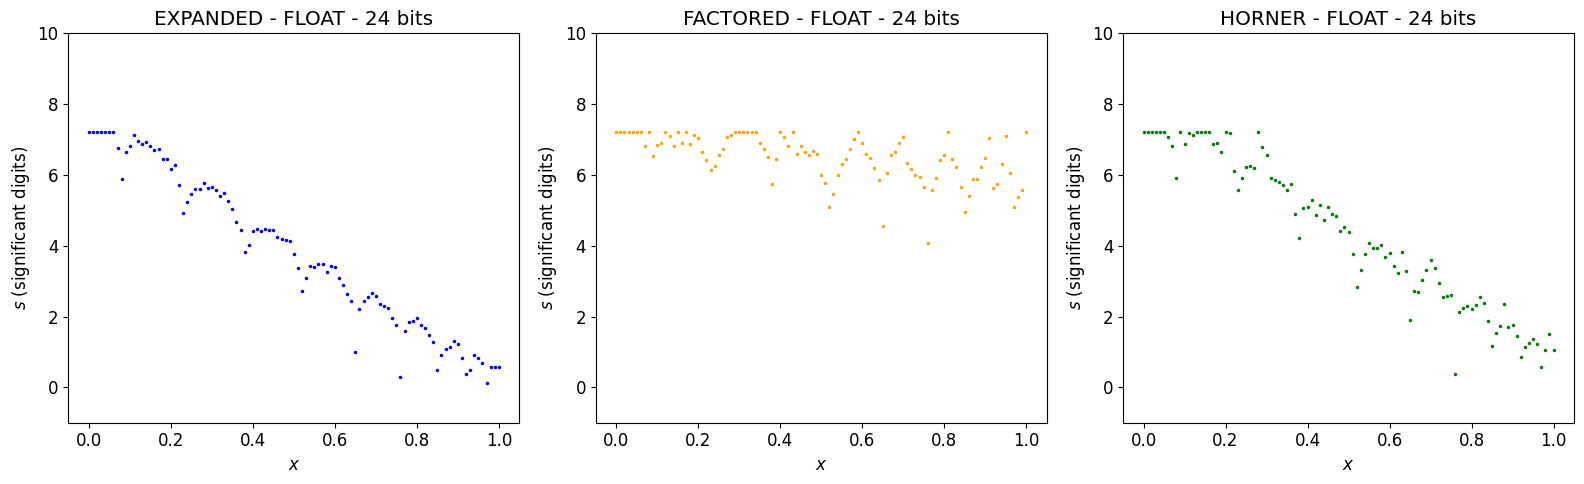

In [80]:
# Compare EXPANDED, FACTORED, and HORNER at 24 bits
results_hor_24 = run_verificarlo(
    f'{WORKDIR}/tchebychev_float', 'HORNER',
    'libinterflop_mca.so --precision-binary32=24 --mode mca',
    x_range, n_samples=20
)

x_vh, mu_h, sigma_h, s_h, samples_h = compute_statistics(results_hor_24, 24)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (label, x_d, s_d, color) in enumerate([
    ('EXPANDED', x_v, s, 'blue'),
    ('FACTORED', x_vf, s_f, 'orange'),
    ('HORNER', x_vh, s_h, 'green'),
]):
    axes[idx].plot(x_d, s_d, '.', markersize=3, color=color)
    axes[idx].set_ylabel('$s$ (significant digits)')
    axes[idx].set_xlabel('$x$')
    axes[idx].set_title(f'{label} - FLOAT - 24 bits')
    axes[idx].set_ylim(bottom=-1, top=10)

plt.tight_layout()
plt.show()

### 6.2 Compensated Horner's Method

*Compensated* algorithms increase program precision without changing the internal working format. The goal is to capture for each operation an estimation of the error term and to reinject it into the result.

For the Horner scheme, we use the Veltkamp-Dekker **TWOPROD** for the product and **TWOSUM** for the sum. These are *Error Free Transforms* (EFT).

The compensated Horner algorithm:

```
PROCEDURE compHorner(x, {a_1, ..., a_n}):
    s_n = a_n, r_n = 0
    FOR i in [n-1 : 0]:
        [p_i, pe_i] = TWOPROD(s_{i+1}, x^2)
        [s_i, se_i] = TWOSUM(p_i, a_i)
        r_i = r_{i+1} * x^2 + (pe_i + se_i)
    RETURN s_0 + r_0
```

> **Warning:** TWOPROD and TWOSUM rely on exact operations; it is essential to use **RR mode** (`--mode rr`) with full precision (53 for double, 24 for float).

In [81]:
# Run COMPHORNER with RR mode (required for EFT correctness)
# FLOAT, precision=24, mode=rr
results_comp_f24 = run_verificarlo(
    f'{WORKDIR}/tchebychev_float', 'COMPHORNER',
    'libinterflop_mca.so --precision-binary32=24 --mode rr',
    x_range, n_samples=20
)

x_vc, mu_c, sigma_c, s_c, samples_c = compute_statistics(results_comp_f24, 24)

# DOUBLE, precision=53, mode=rr
results_comp_d53 = run_verificarlo(
    f'{WORKDIR}/tchebychev_double', 'COMPHORNER',
    'libinterflop_mca.so --precision-binary64=53 --mode rr',
    x_range, n_samples=20
)

x_vc53, mu_c53, sigma_c53, s_c53, samples_c53 = compute_statistics(results_comp_d53, 53)

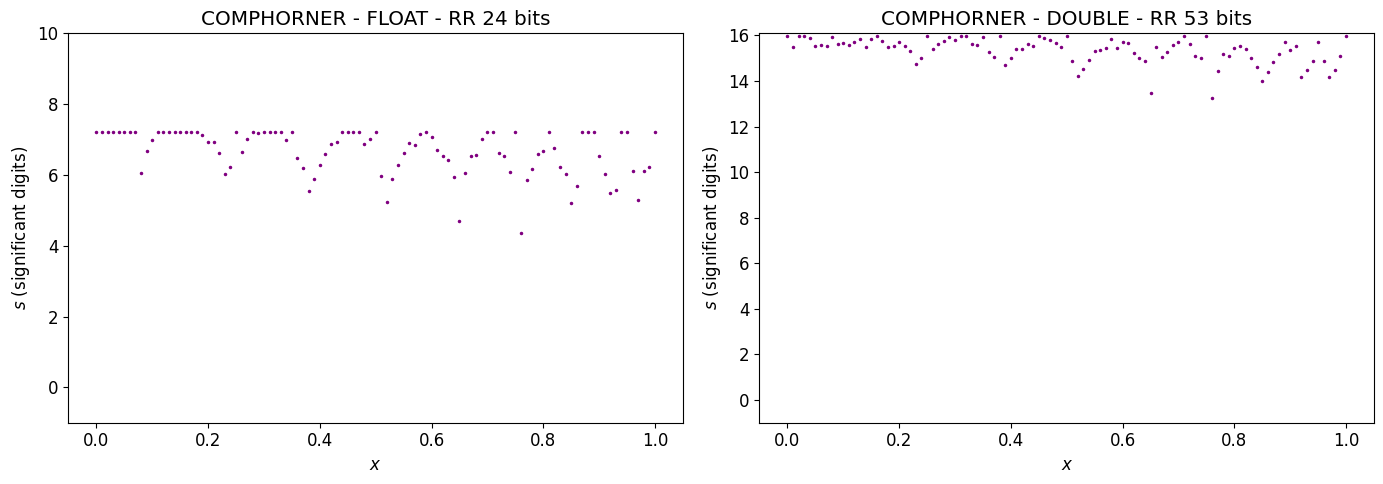

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(x_vc, s_c, '.', markersize=3, color='purple')
axes[0].set_ylabel('$s$ (significant digits)')
axes[0].set_xlabel('$x$')
axes[0].set_title('COMPHORNER - FLOAT - RR 24 bits')
axes[0].set_ylim(bottom=-1, top=10)

axes[1].plot(x_vc53, s_c53, '.', markersize=3, color='purple')
axes[1].set_ylabel('$s$ (significant digits)')
axes[1].set_xlabel('$x$')
axes[1].set_title('COMPHORNER - DOUBLE - RR 53 bits')
axes[1].set_ylim(bottom=-1)

plt.tight_layout()
plt.show()

### All Methods Comparison

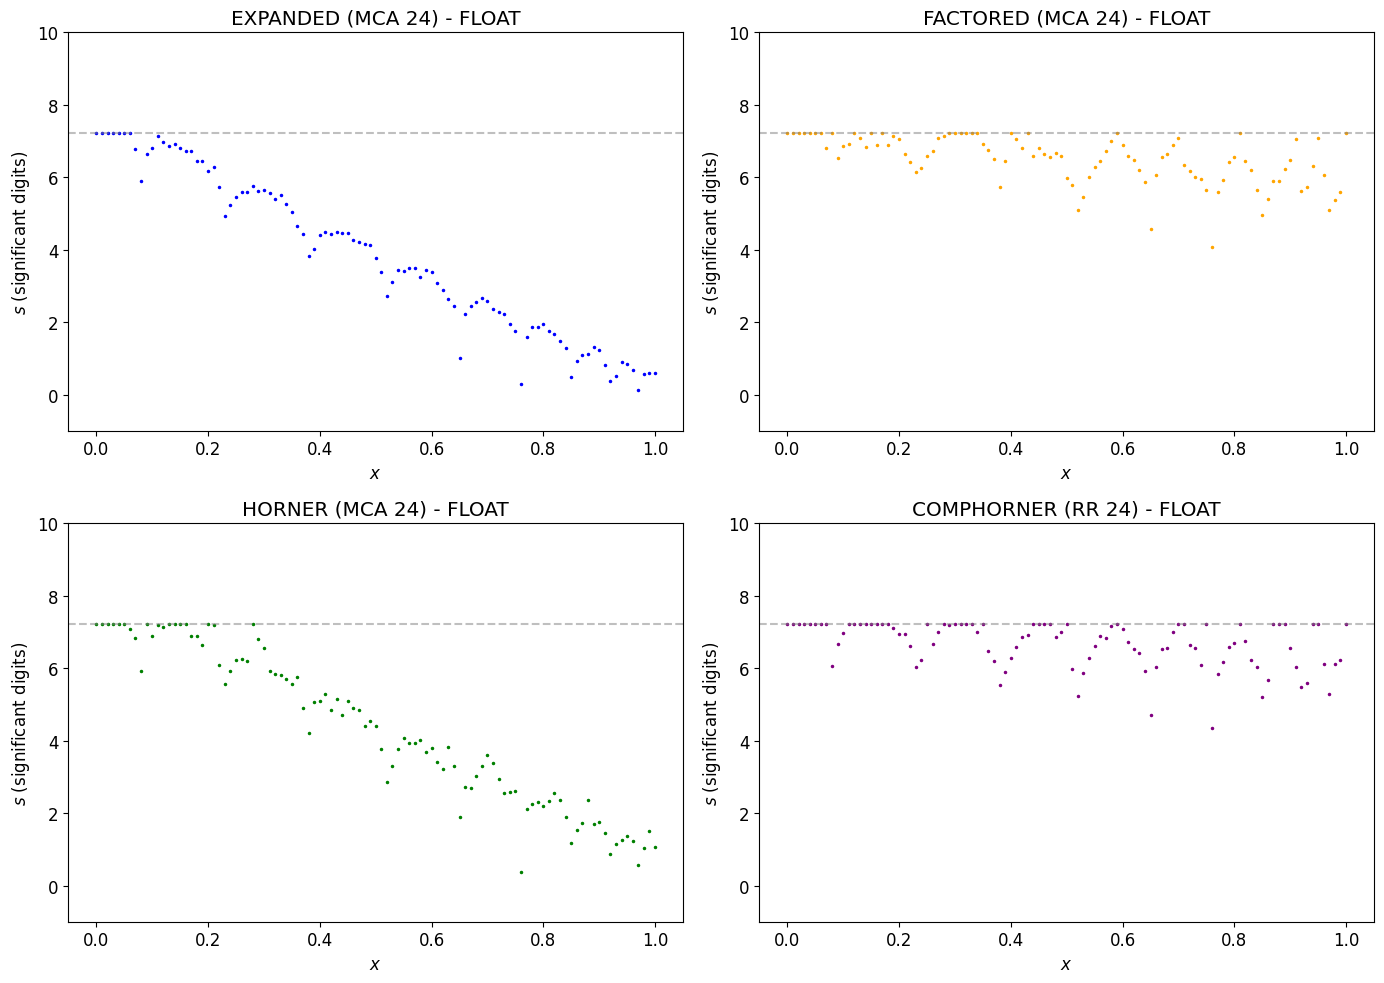

In [83]:
# Compare all methods side by side at FLOAT 24 bits
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, (label, x_d, s_d, color) in zip(
    axes.flat,
    [
        ('EXPANDED (MCA 24)', x_v, s, 'blue'),
        ('FACTORED (MCA 24)', x_vf, s_f, 'orange'),
        ('HORNER (MCA 24)', x_vh, s_h, 'green'),
        ('COMPHORNER (RR 24)', x_vc, s_c, 'purple'),
    ]
):
    ax.plot(x_d, s_d, '.', markersize=3, color=color)
    ax.set_ylabel('$s$ (significant digits)')
    ax.set_xlabel('$x$')
    ax.set_title(f'{label} - FLOAT')
    ax.set_ylim(bottom=-1, top=10)
    ax.axhline(y=24 * math.log10(2), color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Observations on CompHorner

CompHorner compensates precision losses in both double and single precision. We retrieve a behavior similar to the factored form, particularly for points where $T(x) = 1$. However, knowing the polynomial's roots is **not** required for using the Horner scheme.

---

## Summary

In this tutorial, we explored:

1. **Verificarlo Basics:** How to compile and run programs with Verificarlo, and how to use different backends (IEEE, MCA, VPREC).

2. **Monte Carlo Arithmetic:** How to use stochastic perturbation to estimate the numerical quality of floating-point computations. We saw how the expanded polynomial evaluation suffers from catastrophic cancellations near $x = 1$.

3. **Factored Form:** How mathematical rewriting of the polynomial can significantly improve numerical stability.

4. **VPREC Backend:** How to deterministically emulate reduced floating-point formats (binary16, bfloat16, custom precisions).

5. **Delta-Debug:** How to automatically localize the source of numerical instability. We identified a catastrophic cancellation in Archimedes' $\pi$ approximation and fixed it with expression rewriting.

6. **Compensated Algorithms:** How Error-Free Transformations (EFT) can recover lost precision without changing the data type.

### References

- D. Stott Parker, *Monte Carlo Arithmetic*, UCLA, 1997.
- A. Zeller, *Automated debugging: Are we close?*, IEEE Computer, 2001.
- S. Graillat, *Compensated Horner Scheme*, 2005.
- Verificarlo: https://github.com/verificarlo/verificarlo